# Vehicle Detection
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
# Functions From the Udacity program lecture notes:
from functions import *


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.ndimage.measurements import label
import pickle
import time

from moviepy.editor import VideoFileClip

# Training Model for Car Recognition

In [3]:
# Training Data for Car recognition

vehicleYES = glob.glob('resource/image/vehicles/**/*.png')
vehicleNO = glob.glob('resource/image/nonVehicles/**/*.png')

nVeh = len(vehicleYES)
nNoVeh = len(vehicleNO)
print("Vehicle images: \t %d \nNon-Vehicle images: \t %d" %(nVeh, nNoVeh))

vehicleImages = []
noVehicleImages = []

# Non-vehicles
for p in vehicleYES:
    img = cv2.imread(p)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    vehicleImages.append(img)
    
for p in vehicleNO:
    img = cv2.imread(p)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    noVehicleImages.append(img)

shape1 = vehicleImages[0].shape
shape2 = noVehicleImages[0].shape



Vehicle images: 	 8792 
Non-Vehicle images: 	 8968
(64, 64, 3) (64, 64, 3)


In [5]:
print("Image shape: ", shape1)

Image shape:  (64, 64, 3)


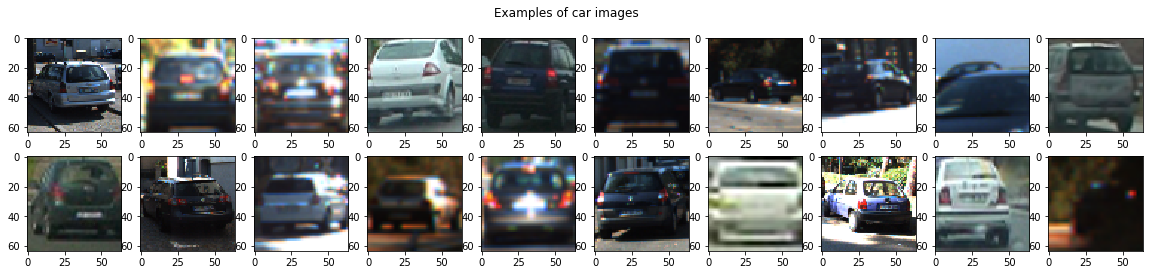

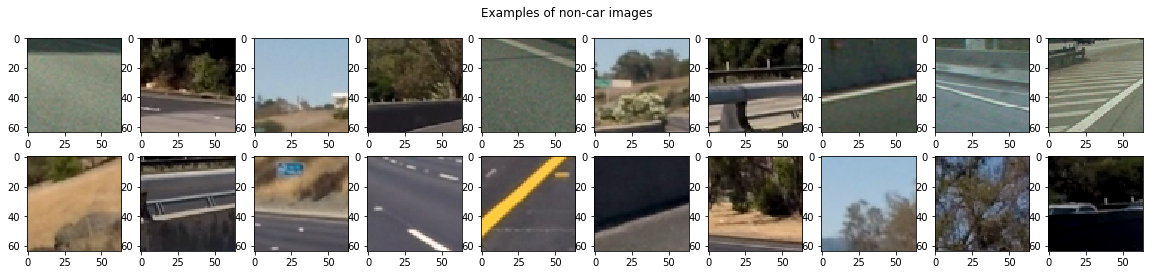

In [6]:
fig1, axs = plt.subplots(2,10, figsize=(20, 4))
# fig1.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
selectRand1 = np.random.choice(nVeh, 20)
for i,s1 in enumerate(selectRand1):
    img = vehicleImages[s1]
    axs[i].imshow(img)
plt.suptitle("Examples of car images")

fig2, axs = plt.subplots(2,10, figsize=(20, 4))
axs = axs.ravel()
selectRand2 = np.random.choice(nNoVeh,20)
for i,s2 in enumerate(selectRand2):
    img = noVehicleImages[s2]
    axs[i].imshow(img)
plt.suptitle("Examples of non-car images")    


fig1.savefig("example/CarImages.png", bbox_inches='tight')
fig2.savefig("example/noCarImages.png", bbox_inches='tight')

### Histogram of Oriented Gradients (HOG) feature extraction on a labeled training

In [7]:
tCarImg = vehicleImages[1234]
tCarImgg = cv2.cvtColor(tCarImg, cv2.COLOR_RGB2GRAY)
tNoCarImg = noVehicleImages[1234]
tNoCarImgg = cv2.cvtColor(tNoCarImg,cv2.COLOR_RGB2GRAY)

orient = 9
pix_per_cell = 8
cell_per_block = 2

tFeatCar, hogImCar = get_hog_features(tCarImgg, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
tFeatNoCar, hogImNoCar = get_hog_features(tNoCarImgg, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

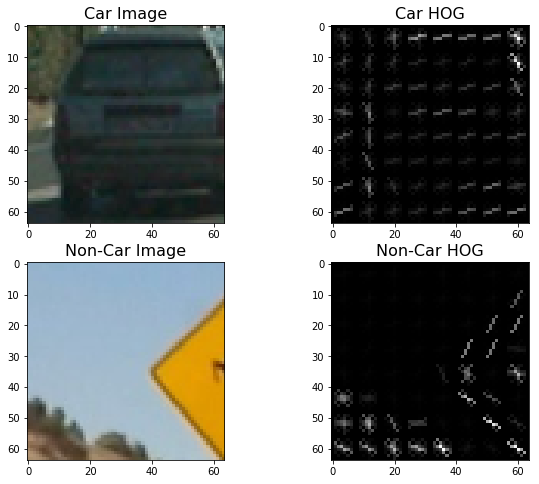

In [9]:

# Visualize 
fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
#fig3.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(tCarImg)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(hogImCar, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(tNoCarImg)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(hogImNoCar, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

fig3.savefig("example/HOGlines.png", bbox_inches='tight')

In [10]:
# Global arguments

colorSpace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orientation = 30  # HOG orientations
pixPerCell = 16 # HOG pixels per cell
cellPerBlock = 2 # HOG cells per block
hogChannel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatialBinSize = (16, 16) # Spatial binning dimensions
histBins = 16  # Number of histogram bins
spatialFeat = False # Spatial features on or off
histFeat = False # Histogram features on or off
hogFeat = True # HOG features on or off



### Apply Feature Extraction to all images (vehicles and non-vehicles).

In [13]:

"""
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* normalize your features and randomize a selection for training and testing.
"""
carFeatures =  extractFeatures(vehicleImages, color_space =colorSpace, spatial_size= spatialBinSize, hist_bins = histBins, 
                               orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                               spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
noCarFeatures =  extractFeatures(noVehicleImages, color_space =colorSpace, spatial_size= spatialBinSize, hist_bins = histBins, 
                               orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                               spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)

# x vector stacked
X = np.vstack((carFeatures, noCarFeatures)).astype(np.float64)  

# Standardize the image data
scalerf = StandardScaler(copy=True, with_mean=True, with_std=True)
scalerf.fit(X)
Xstd = scalerf.transform(X)


# y vector 
y = np.hstack((np.ones(nVeh), np.zeros(nNoVeh)))

assert len(Xstd)==len(y)

In [17]:
# Randomize train and test sample. use sklearn
# for reproducibility set random splitting seed
seed = 12345

xtrain, xtest, ytrain, ytest = train_test_split(Xstd, y, test_size=0.33, random_state=seed)

t0 = time.time()
clf = svm.SVC(kernel="rbf")
clf.fit(xtrain, ytrain)
predAccuracy = clf.score(xtest, ytest)
t1 = time.time()
print('Time elapsed: ', round(t1-t0, 2))
print("Prediction accuracy: ", predAccuracy)
clf



Time elapsed:  250.85
Prediction accuracy:  0.974236478417


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
# Other tried model fitting: different kernel functions

# Time elapsed:  531.39
# Prediction accuracy:  0.933629073537
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

# Time elapsed:  148.34
# Prediction accuracy:  0.952738440539
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

# Time elapsed:  262.23
# Prediction accuracy:  0.7874082921
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

In [18]:
# Save model
with open('resource/model1.p', 'wb') as f:
    pickle.dump({'modelFit': clf, "scaler": scalerf}, f)
    
# #To Load
# with open('resource/model1.p', 'rb') as f:
#     modelDict = pickle.load(f)
#     clf = modelDict['modelFit']
#     scalerf = modelDict['scaler']


## Sliding-window and trained classifier to search for vehicles in images

In [3]:
tImage = cv2.imread("resource/test_images/test1.jpg")
tImage = cv2.cvtColor(tImage, cv2.COLOR_BGR2RGB)

In [4]:
# # To load:
with open('resource/model1.p', 'rb') as f:
    modelDict = pickle.load(f)
    clf = modelDict['modelFit']
    scalerf = modelDict['scaler']

colorSpace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orientation = 30  # HOG orientations
pixPerCell = 16 # HOG pixels per cell
cellPerBlock = 2 # HOG cells per block
hogChannel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatialBinSize = (16, 16) # Spatial binning dimensions
histBins = 16  # Number of histogram bins
spatialFeat = False # Spatial features. Need To Debug
histFeat = False # Histogram featurer. Need to debug
hogFeat = True # HOG features on or off

In [5]:



h,w = tImage.shape[0:2]

yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
xMinMax = [0, w] # slide_window() x axis search area

windowsM = slide_window(tImage, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(120, 120), xy_overlap=(0.7, 0.7))
windowsS = slide_window(tImage, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(60, 60), xy_overlap=(0.6, 0.6))
windowsL = slide_window(tImage, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(200, 200), xy_overlap=(0.8, 0.8))

hotWindowsS = search_windows(tImage, windowsS, clf, scaler=scalerf, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
hotWindowsM = search_windows(tImage, windowsM, clf, scaler=scalerf, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
hotWindowsL = search_windows(tImage, windowsL, clf, scaler=scalerf, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)

hotWindows= hotWindowsL+hotWindowsM+hotWindowsS

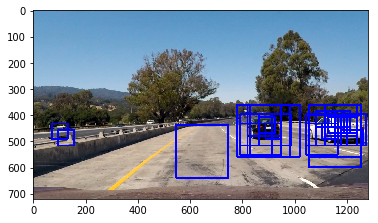

In [6]:
drawImage = np.copy(tImage)
windowImg = draw_boxes(drawImage, hotWindows, color=(0, 0, 255), thick=6)  
plt.imshow(windowImg)


2 cars found


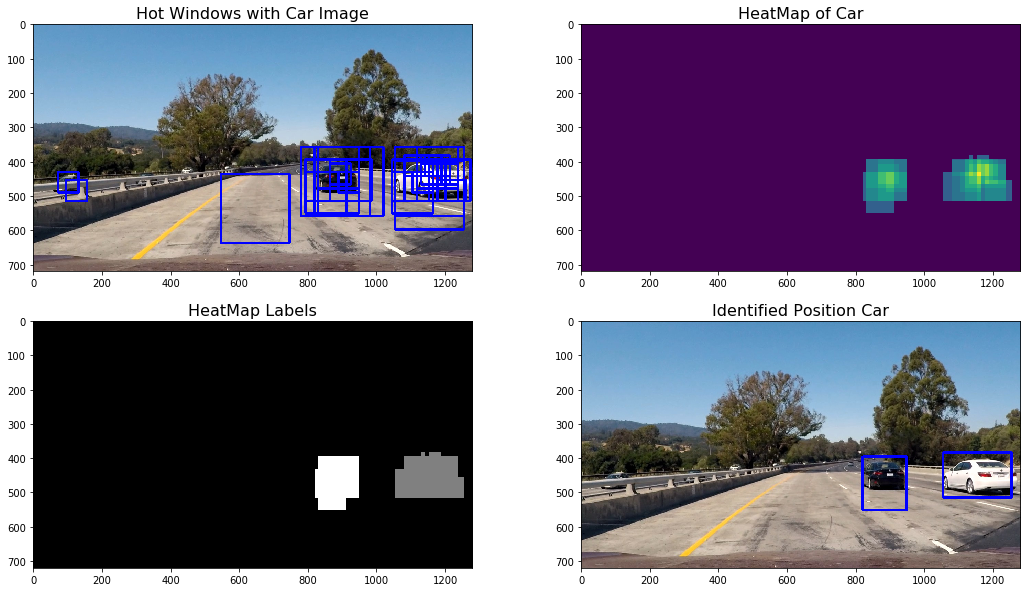

In [7]:
# Calculate and draw heat map

heatmapThresh = 3
heatmap = np.zeros((h, w)) 
heatmap = add_heat(heatmap, hotWindows)
heatmap = apply_threshold(heatmap, heatmapThresh)
labels = label(heatmap)

# Draw final bounding boxes
draw_img, ncar = drawLabeledBboxes(tImage, labels)
print(ncar, 'cars found')

fig5, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,10))
#fig3.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(windowImg)
ax1.set_title('Hot Windows with Car Image', fontsize=16)
ax2.imshow(heatmap)
ax2.set_title('HeatMap of Car', fontsize=16)
ax3.imshow(labels[0], cmap='gray')
ax3.set_title('HeatMap Labels', fontsize=16)
ax4.imshow(draw_img)
ax4.set_title('Identified Position Car', fontsize=16)

fig5.savefig("example/WindowSearchVehicle.png", bbox_inches='tight')

In [8]:
def detectCar(img, xScaler, classModel, heatmapThresh = 3):
    """
    Pipeline to detect car, given previously trained model to recognize car
    """
    global colorSpace, spatialBinSize, histBins, orientation, pixPerCell, cellPerBlock, hogChannel
    global spatialFeat, histFeat, hogFeat
            
    h,w = img.shape[0:2]

    yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
    xMinMax = [0, w] # slide_window() x axis search area
    
    windowsM = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(120, 120), xy_overlap=(0.7, 0.7))
    windowsS = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(60, 60), xy_overlap=(0.6, 0.6))
    windowsL = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(200, 200), xy_overlap=(0.8, 0.8))

    hotWindowsS = search_windows(img, windowsS, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsM = search_windows(img, windowsM, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsL = search_windows(img, windowsL, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)

    hotWindows= hotWindowsL+hotWindowsM+hotWindowsS
    
    heatmap = np.zeros((h, w)) 
    heatmap = add_heat(heatmap, hotWindows)
    heatmap = apply_threshold(heatmap, heatmapThresh)
    labels = label(heatmap)
    
    drawImage = np.copy(img)

    windowImg = draw_boxes(drawImage, hotWindows, color=(0, 0, 255), thick=6)  

    # Draw final bounding boxes
    drawFinalBox, ncar = drawLabeledBboxes(drawImage, labels)
    print("number of cars: ", ncar)
    
    return windowImg, heatmap, drawFinalBox
    

number of cars:  2
number of cars:  0
number of cars:  1
number of cars:  2
number of cars:  2
number of cars:  2


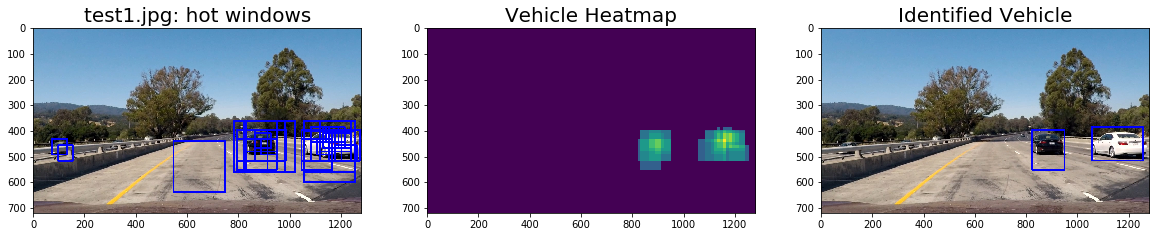

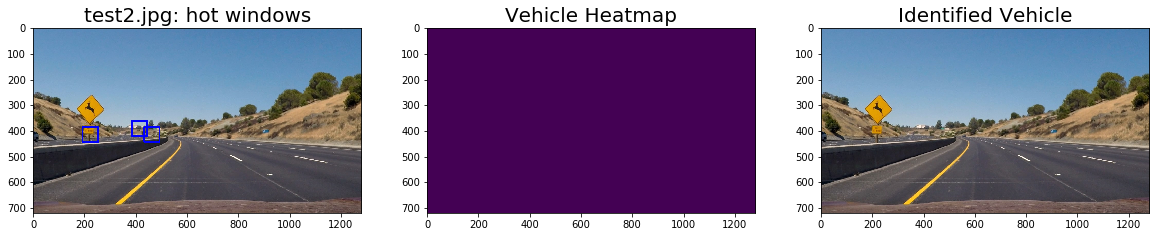

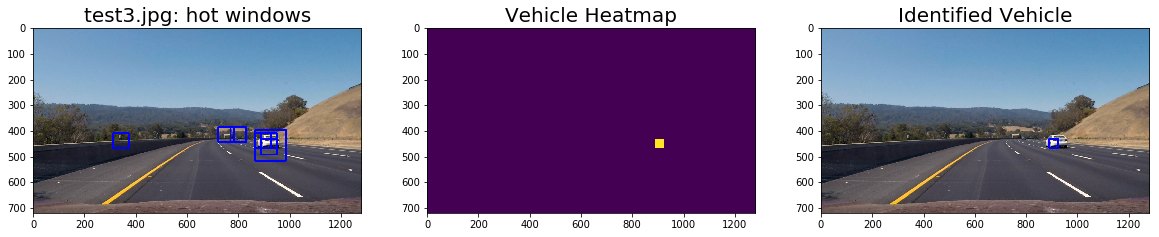

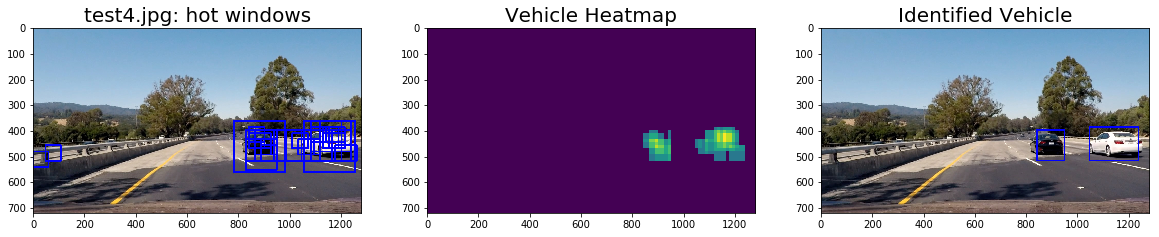

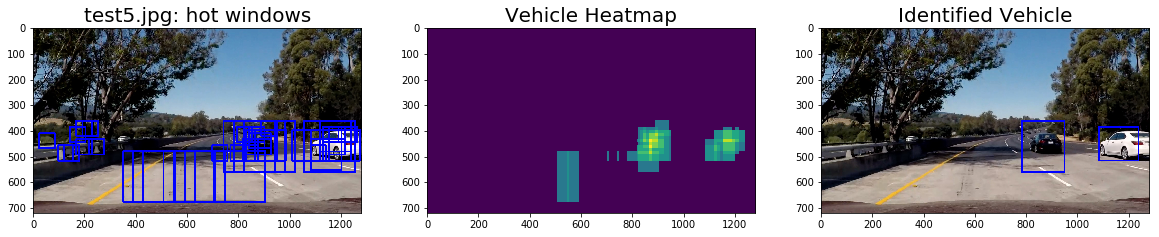

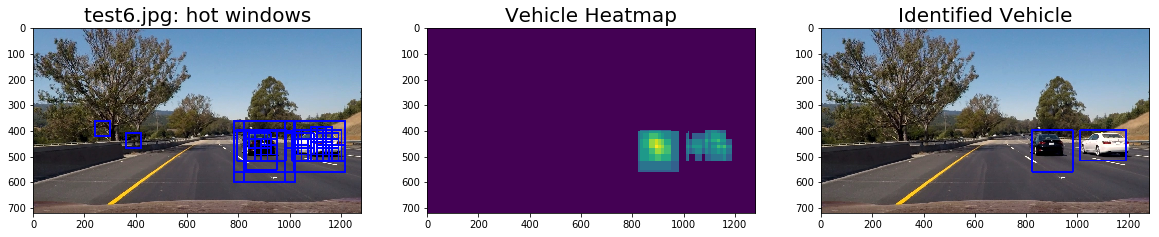

In [68]:
# Apply pipeline to all test images
imagesPath = glob.glob("resource/test_images/*jpg")
outPath = "output_images"  
for p in imagesPath:
    f = plt.figure(figsize=(20, 4))
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imName = os.path.basename(p)
    windowImg, heatmap, drawFinalBox = detectCar(img, xScaler=scalerf, classModel=clf, heatmapThresh=3)
    plt.subplot(1,3,1)
    plt.imshow(windowImg)
    plt.title(imName + ": hot windows", fontsize=20)
    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.title("Vehicle Heatmap", fontsize=20)
    plt.subplot(1,3,3)
    plt.imshow(drawFinalBox)
    plt.title("Identified Vehicle", fontsize=20)
    f.savefig(os.path.join(outPath, imName), bbox_inches='tight')
    

## Video Images Vehicle Detection Pipeline

In [9]:
class cHotWindows():
    """
    Class that keeps in memory previously found hot windows and and count number of cumulative hot window over time. If subsequent 
    frames also contain hot windows than detect vehicle
    
    self.windows is a queue of lists of boxes. Each window can be of arbitrary size.
    """
    def __init__(self, n):
        self.n = n
        # initialize emply list
        self.windows = [] 
        self.nFrame = 0
        self.nWinList = 0

    def setWindows(self, newWindows):
        """
        Push new windows to queue 
        remove 1st element from queue if full
        """
        self.windows.append(newWindows)
        
        # Count number of frames and number of windows list
        self.nFrame += 1
        self.nWinList = len(self.windows)

        full = len(self.windows) >= self.n
        if full:
            # remove first window from the list
            self.windows.pop(0)
            self.nFrame -=1
            self.nWinList -=1
            

    def getWindows(self):
        """
        Concatenate all lists of windows and return as one list
        """
        outWindows = []
        for window in self.windows:
            outWindows = outWindows + window
          
        return outWindows, self.nFrame, self.nWinList


In [10]:
def detectCarImSequence(img, xScaler, classModel, baseheatmapThresh = 3):
    """ 
    Given input_file video, save annotated video to output_file 
    """
    # global instance of class storing previously detected hot windows
    global cHotWindowsInst
    
    global colorSpace, spatialBinSize, histBins, orientation, pixPerCell, cellPerBlock, hogChannel
    global spatialFeat, histFeat, hogFeat
    
    #global h, w, yMinMax, xMinMax
    h,w = img.shape[0:2]

    yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
    xMinMax = [0, w] # slide_window() x axis search area
    
    windowsM = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(120, 120), xy_overlap=(0.7, 0.7))
    windowsS = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(60, 60), xy_overlap=(0.6, 0.6))
    windowsL = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(200, 200), xy_overlap=(0.8, 0.8))

    hotWindowsS = search_windows(img, windowsS, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsM = search_windows(img, windowsM, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsL = search_windows(img, windowsL, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)

    hotWindows= hotWindowsL+hotWindowsM+hotWindowsS
        
    # Class containing windows
    cHotWindowsInst.setWindows(hotWindows)
    
    # get all windows
    cumWindows, nFrame, nWinL = cHotWindowsInst.getWindows()
    
    # Set the threshold based on number of frame and number of window identified
    heatmapThresh = int(baseheatmapThresh * nFrame)
    
    ## Note: for the first image cumWindows is equivalent to hotWindows
        

    heatmap = np.zeros((h, w)) 
    heatmap = add_heat(heatmap, cumWindows)
    heatmap = apply_threshold(heatmap, heatmapThresh)
    labels = label(heatmap)

    drawImage = np.copy(img)

   # windowImg = draw_boxes(drawImage, hotWindows, color=(0, 0, 255), thick=6)  
   
    # Draw final bounding boxes
    drawFinalBox, ncar = drawLabeledBboxes(drawImage, labels)
  #  print("number of cars: ", ncar)

    return drawFinalBox
    
    
def detectFun(img):
    return detectCarImSequence(img, xScaler=scalerf, classModel=clf, baseheatmapThresh = 3)  


#### Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles

In [8]:
# img = cv2.imread("resource/test_images/test1.jpg")
# h,w = img.shape[0:2]
# yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
# xMinMax = [0, w] # slide_window() x axis search area



In [73]:
cHotWindowsInst = cHotWindows(n=4)
video0 = VideoFileClip("resource/test_video.mp4")
detVideo0 = video0.fl_image(detectFun)
detVideo0.write_videofile("example/test_video_carDetection.mp4", audio=False)

[MoviePy] >>>> Building video example/test_video_carDetection.mp4
[MoviePy] Writing video example/test_video_carDetection.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [11:33<00:18, 18.67s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: example/test_video_carDetection.mp4 



In [11]:

cHotWindowsInst = cHotWindows(n=4)
video1 = VideoFileClip("resource/project_video.mp4")
detVideo1 = video1.fl_image(detectFun)
detVideo1.write_videofile("carDetectionVideo.mp4", audio=False)


[MoviePy] >>>> Building video carDetectionVideo.mp4
[MoviePy] Writing video carDetectionVideo.mp4


OSError: [WinError 6] The handle is invalid